<a href="https://colab.research.google.com/github/aarohishaiva/CNN_final-Project/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
!pip install torch torchvision

# Install scikit-learn (for precision, recall, and F1-score calculations)
!pip install scikit-learn

# Install matplotlib (for plotting)
!pip install matplotlib

# Install tqdm (for progress bar)
!pip install tqdm

Files already downloaded and verified
Files already downloaded and verified
Training LeNet-5 Model on CIFAR-10 Dataset:


100%|██████████| 391/391 [00:24<00:00, 16.10it/s]


Epoch [1/5], Train Loss: 1.9055, Test Loss: 1.6513, Accuracy: 0.3947, Precision: 0.3817, Recall: 0.3947, F1-score: 0.3766


100%|██████████| 391/391 [00:22<00:00, 17.47it/s]


Epoch [2/5], Train Loss: 1.5692, Test Loss: 1.4419, Accuracy: 0.4721, Precision: 0.4686, Recall: 0.4721, F1-score: 0.4649


100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


Epoch [3/5], Train Loss: 1.4346, Test Loss: 1.4141, Accuracy: 0.4907, Precision: 0.4994, Recall: 0.4907, F1-score: 0.4853


100%|██████████| 391/391 [00:23<00:00, 16.90it/s]


Epoch [4/5], Train Loss: 1.3601, Test Loss: 1.3187, Accuracy: 0.5247, Precision: 0.5242, Recall: 0.5247, F1-score: 0.5143


100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Epoch [5/5], Train Loss: 1.3135, Test Loss: 1.3032, Accuracy: 0.5332, Precision: 0.5374, Recall: 0.5332, F1-score: 0.5261


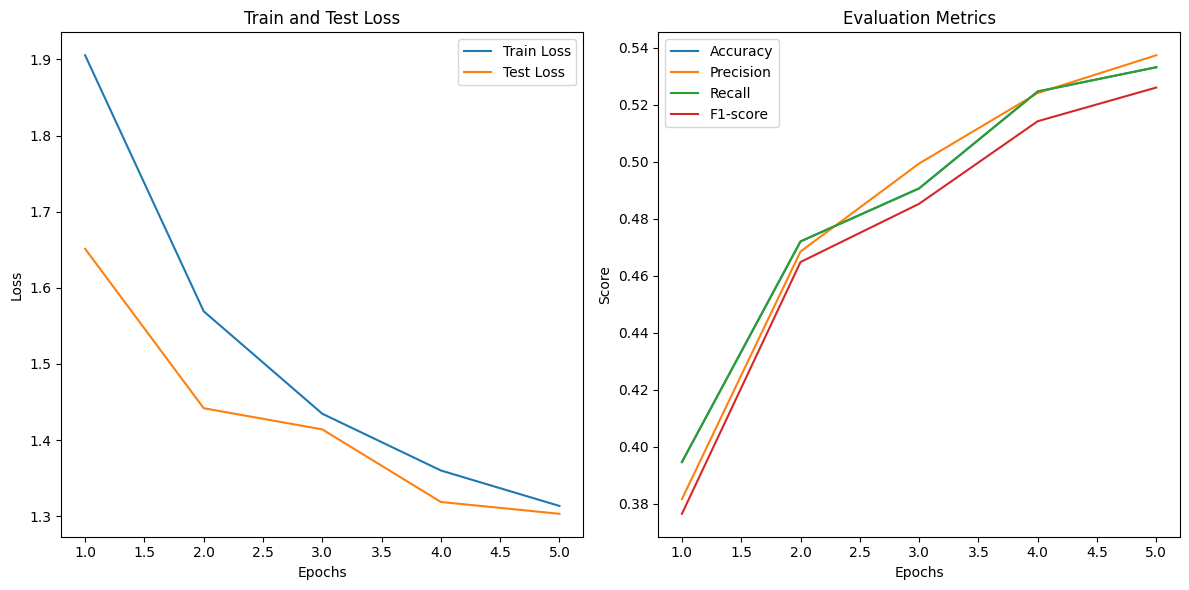

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Modified LeNet-5 for CIFAR-10 (32x32 color images)
class LeNet5CIFAR(nn.Module):
    def __init__(self):
        super(LeNet5CIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)    # Input: 3x32x32, Output: 6x28x28
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 6x14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)   # Output: 16x10x10
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Data preparation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
lenet5_cifar_model = LeNet5CIFAR()
print("Training LeNet-5 Model on CIFAR-10 Dataset:")
train_losses, test_losses, metrics = train_model(lenet5_cifar_model, train_loader, test_loader, num_epochs=5)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Files already downloaded and verified
Files already downloaded and verified
Training AlexNet Model on CIFAR-10 Dataset:


100%|██████████| 391/391 [26:00<00:00,  3.99s/it]


Epoch [1/5], Train Loss: 1.7433, Test Loss: 1.3684, Accuracy: 0.4967, Precision: 0.4951, Recall: 0.4967, F1-score: 0.4815


100%|██████████| 391/391 [28:26<00:00,  4.36s/it]


Epoch [2/5], Train Loss: 1.3009, Test Loss: 1.1239, Accuracy: 0.5887, Precision: 0.5951, Recall: 0.5887, F1-score: 0.5801


100%|██████████| 391/391 [29:55<00:00,  4.59s/it]


Epoch [3/5], Train Loss: 1.1106, Test Loss: 1.0056, Accuracy: 0.6416, Precision: 0.6482, Recall: 0.6416, F1-score: 0.6414


100%|██████████| 391/391 [29:33<00:00,  4.54s/it]


Epoch [4/5], Train Loss: 0.9770, Test Loss: 0.9130, Accuracy: 0.6849, Precision: 0.6907, Recall: 0.6849, F1-score: 0.6844


100%|██████████| 391/391 [29:14<00:00,  4.49s/it]


Epoch [5/5], Train Loss: 0.8660, Test Loss: 0.8589, Accuracy: 0.6978, Precision: 0.7097, Recall: 0.6978, F1-score: 0.6960


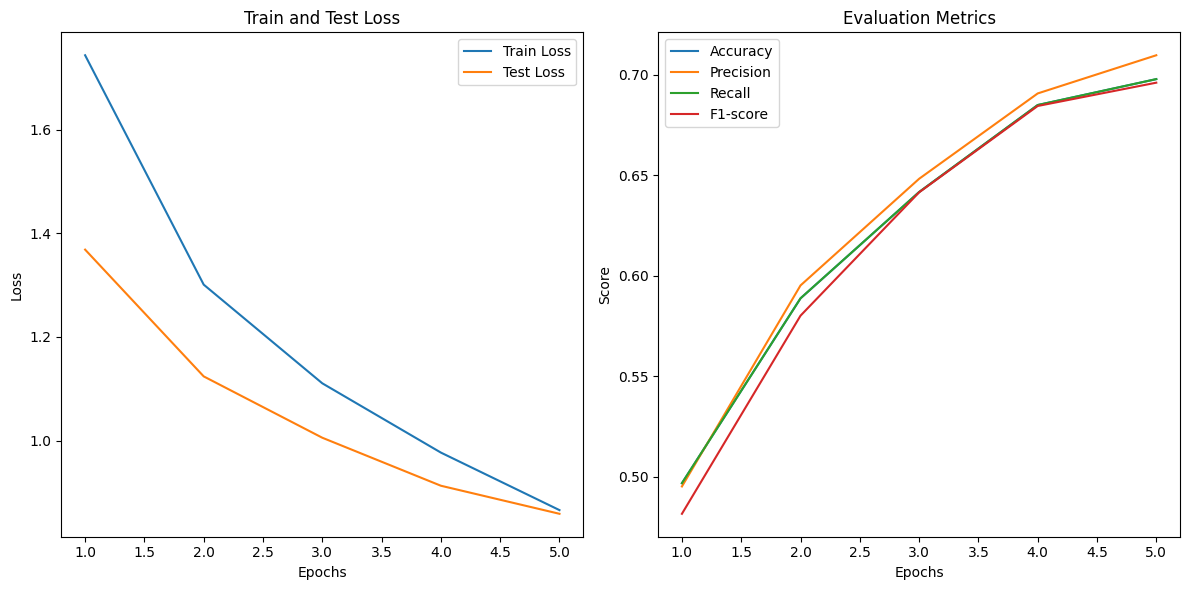

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Modified AlexNet for CIFAR-10
class AlexNetCIFAR(nn.Module):
    def __init__(self):
        super(AlexNetCIFAR, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 64x16x16
            nn.Conv2d(64, 192, kernel_size=3, padding=1),          # Output: 192x16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 192x8x8
            nn.Conv2d(192, 384, kernel_size=3, padding=1),         # Output: 384x8x8
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),         # Output: 256x8x8
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),         # Output: 256x8x8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # Output: 256x4x4
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

# Data preparation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function
def train_model(model, train_loader, test_loader, num_epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
alexnet_cifar_model = AlexNetCIFAR()
print("Training AlexNet Model on CIFAR-10 Dataset:")
train_losses, test_losses, metrics = train_model(alexnet_cifar_model, train_loader, test_loader, num_epochs=5)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Files already downloaded and verified
Files already downloaded and verified
Training GoogleNet Model on CIFAR-10 Dataset:


100%|██████████| 391/391 [03:11<00:00,  2.04it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/5], Train Loss: 2.0098, Test Loss: 1.8538, Accuracy: 0.2964, Precision: 0.2648, Recall: 0.2964, F1-score: 0.2494


100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch [2/5], Train Loss: 1.7076, Test Loss: 1.6263, Accuracy: 0.3900, Precision: 0.4229, Recall: 0.3900, F1-score: 0.3783


100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch [3/5], Train Loss: 1.5281, Test Loss: 1.4728, Accuracy: 0.4540, Precision: 0.4614, Recall: 0.4540, F1-score: 0.4491


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch [4/5], Train Loss: 1.4200, Test Loss: 1.3557, Accuracy: 0.5009, Precision: 0.5070, Recall: 0.5009, F1-score: 0.4935


100%|██████████| 391/391 [03:12<00:00,  2.03it/s]


Epoch [5/5], Train Loss: 1.3484, Test Loss: 1.3727, Accuracy: 0.4909, Precision: 0.5365, Recall: 0.4909, F1-score: 0.4923


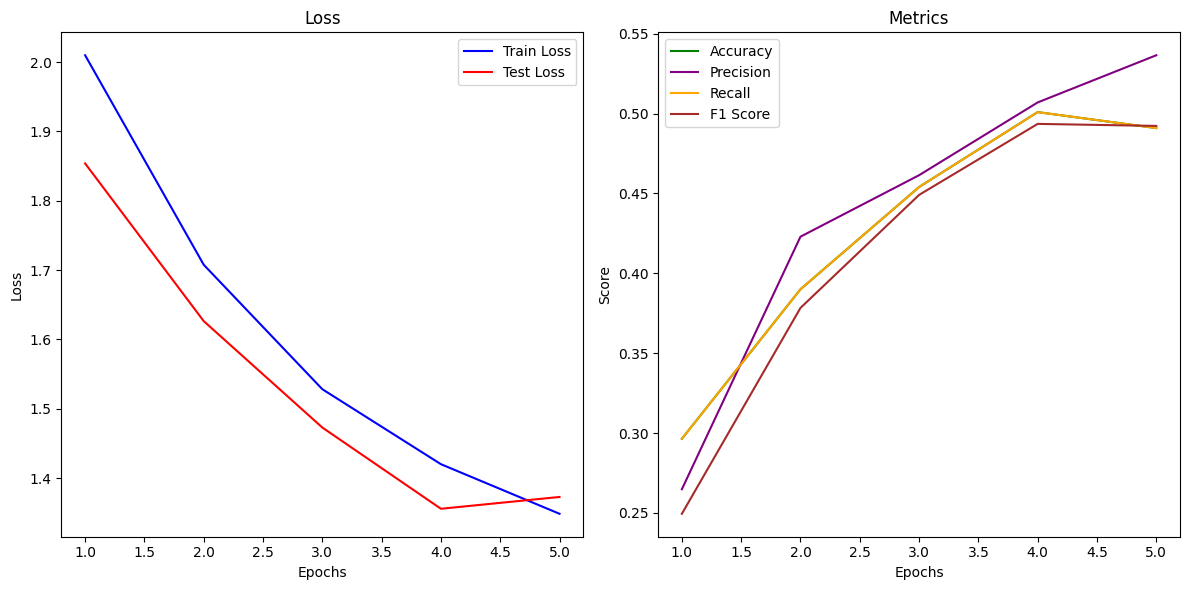

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Inception Module Definition
class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 24, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 24, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 24, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1x1(x)
        branch5 = self.branch5x5(x)
        branch3 = self.branch3x3(x)
        branch_pool = self.branch_pool(x)

        outputs = [branch1, branch5, branch3, branch_pool]
        return torch.cat(outputs, 1)

# GoogleNet Model Definition
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # First Inception module
        self.inception1 = InceptionModule(64)
        # Output channels from inception1 = 16 + 24 + 24 + 24 = 88
        self.inception2 = InceptionModule(88)  # Pass correct channel count
        # Output channels from inception2 = 16 + 24 + 24 + 24 = 88
        self.inception3 = InceptionModule(88)  # Pass correct channel count
        # Output channels from inception3 = 16 + 24 + 24 + 24 = 88
        self.inception4 = InceptionModule(88)  # Pass correct channel count

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(88, 10)  # Adjust for final output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)

        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.inception4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data Preparation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function
def train_model(model, train_loader, test_loader, num_epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', color='red')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['accuracy'], label='Accuracy', color='green')
    plt.plot(epochs, metrics['precision'], label='Precision', color='purple')
    plt.plot(epochs, metrics['recall'], label='Recall', color='orange')
    plt.plot(epochs, metrics['f1_score'], label='F1 Score', color='brown')
    plt.title('Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Model Training
googlenet_model = GoogleNet()
print("Training GoogleNet Model on CIFAR-10 Dataset:")
train_losses, test_losses, metrics = train_model(googlenet_model, train_loader, test_loader, num_epochs=5)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Files already downloaded and verified
Files already downloaded and verified
Training VGGNet Model on CIFAR-10 Dataset:


100%|██████████| 391/391 [18:17<00:00,  2.81s/it]


Epoch [1/5], Train Loss: 1.7365, Test Loss: 1.3564, Accuracy: 0.5009, Precision: 0.5156, Recall: 0.5009, F1-score: 0.4905


100%|██████████| 391/391 [18:03<00:00,  2.77s/it]


Epoch [2/5], Train Loss: 1.2358, Test Loss: 1.0678, Accuracy: 0.6232, Precision: 0.6469, Recall: 0.6232, F1-score: 0.6273


100%|██████████| 391/391 [18:10<00:00,  2.79s/it]


Epoch [3/5], Train Loss: 0.9809, Test Loss: 0.8675, Accuracy: 0.6984, Precision: 0.6981, Recall: 0.6984, F1-score: 0.6951


100%|██████████| 391/391 [18:11<00:00,  2.79s/it]


Epoch [4/5], Train Loss: 0.8300, Test Loss: 0.7874, Accuracy: 0.7274, Precision: 0.7310, Recall: 0.7274, F1-score: 0.7257


100%|██████████| 391/391 [18:24<00:00,  2.83s/it]


Epoch [5/5], Train Loss: 0.6958, Test Loss: 0.7077, Accuracy: 0.7576, Precision: 0.7647, Recall: 0.7576, F1-score: 0.7575


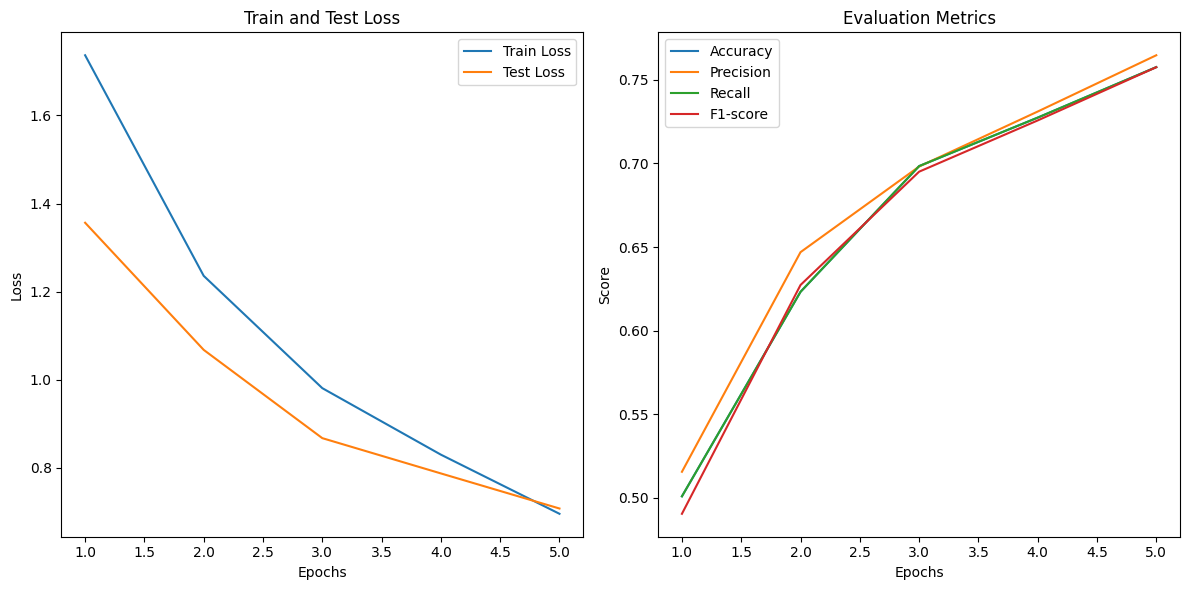

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define a simplified version of VGGNet for CIFAR-10
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Data preparation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function
def train_model(model, train_loader, test_loader, num_epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
vggnet_cifar_model = VGGNet()
print("Training VGGNet Model on CIFAR-10 Dataset:")
train_losses, test_losses, metrics = train_model(vggnet_cifar_model, train_loader, test_loader, num_epochs=5)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Files already downloaded and verified
Files already downloaded and verified
Training ResNet Model on CIFAR-10 Dataset:


100%|██████████| 391/391 [44:49<00:00,  6.88s/it]


Epoch [1/5], Train Loss: 1.3058, Test Loss: 1.0442, Accuracy: 0.6265, Precision: 0.6588, Recall: 0.6265, F1-score: 0.6317


100%|██████████| 391/391 [46:37<00:00,  7.16s/it]


Epoch [2/5], Train Loss: 0.8429, Test Loss: 0.9412, Accuracy: 0.6833, Precision: 0.7181, Recall: 0.6833, F1-score: 0.6760


100%|██████████| 391/391 [46:17<00:00,  7.10s/it]


Epoch [3/5], Train Loss: 0.6364, Test Loss: 0.7517, Accuracy: 0.7431, Precision: 0.7679, Recall: 0.7431, F1-score: 0.7406


100%|██████████| 391/391 [46:15<00:00,  7.10s/it]


Epoch [4/5], Train Loss: 0.5093, Test Loss: 0.6298, Accuracy: 0.7871, Precision: 0.7982, Recall: 0.7871, F1-score: 0.7845


100%|██████████| 391/391 [46:12<00:00,  7.09s/it]


Epoch [5/5], Train Loss: 0.4171, Test Loss: 0.5453, Accuracy: 0.8136, Precision: 0.8225, Recall: 0.8136, F1-score: 0.8124


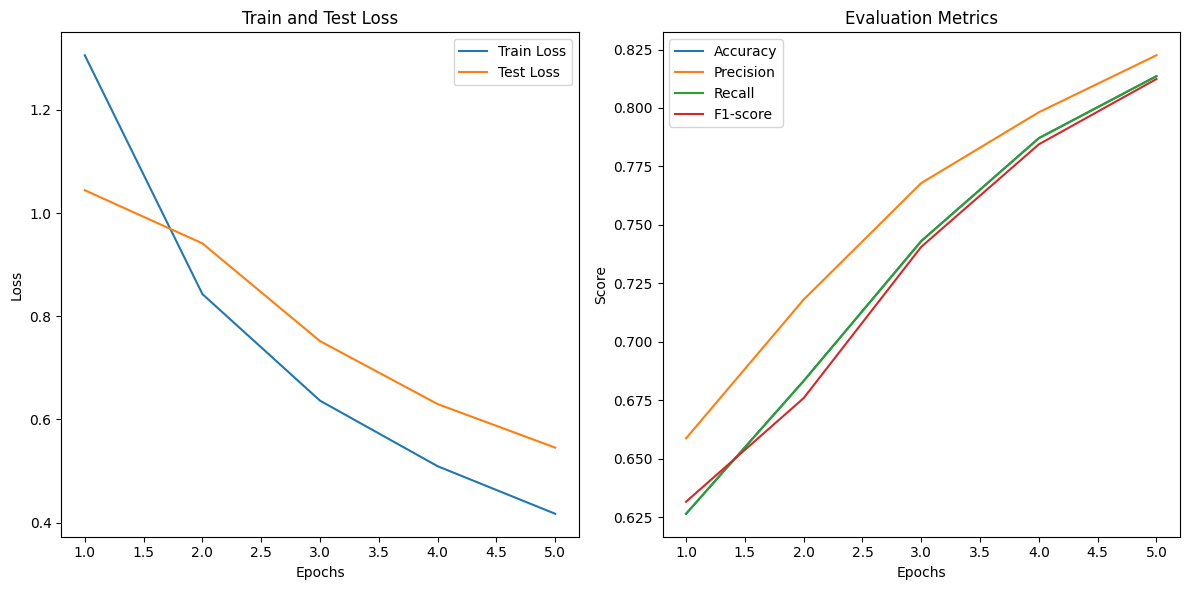

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define a simple Residual Block for ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Adjust channels for residual connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the ResNet Model for CIFAR-10
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        layer = []
        layer.append(ResidualBlock(in_channels, out_channels, stride))
        layer.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data preparation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function
def train_model(model, train_loader, test_loader, num_epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
resnet_cifar_model = ResNet()
print("Training ResNet Model on CIFAR-10 Dataset:")
train_losses, test_losses, metrics = train_model(resnet_cifar_model, train_loader, test_loader, num_epochs=5)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Files already downloaded and verified
Files already downloaded and verified
Training Xception-like Model on CIFAR-10 Dataset:


100%|██████████| 391/391 [04:20<00:00,  1.50it/s]


Epoch [1/5], Train Loss: 1.4424, Test Loss: 1.3875, Accuracy: 0.5053, Precision: 0.5882, Recall: 0.5053, F1-score: 0.5171


100%|██████████| 391/391 [04:12<00:00,  1.55it/s]


Epoch [2/5], Train Loss: 1.0819, Test Loss: 1.0665, Accuracy: 0.6237, Precision: 0.6384, Recall: 0.6237, F1-score: 0.6216


100%|██████████| 391/391 [04:09<00:00,  1.57it/s]


Epoch [3/5], Train Loss: 0.9297, Test Loss: 1.0753, Accuracy: 0.6273, Precision: 0.6466, Recall: 0.6273, F1-score: 0.6161


100%|██████████| 391/391 [04:16<00:00,  1.52it/s]


Epoch [4/5], Train Loss: 0.8332, Test Loss: 1.1817, Accuracy: 0.5867, Precision: 0.6727, Recall: 0.5867, F1-score: 0.5735


100%|██████████| 391/391 [04:08<00:00,  1.57it/s]


Epoch [5/5], Train Loss: 0.7558, Test Loss: 0.9377, Accuracy: 0.6743, Precision: 0.6818, Recall: 0.6743, F1-score: 0.6665


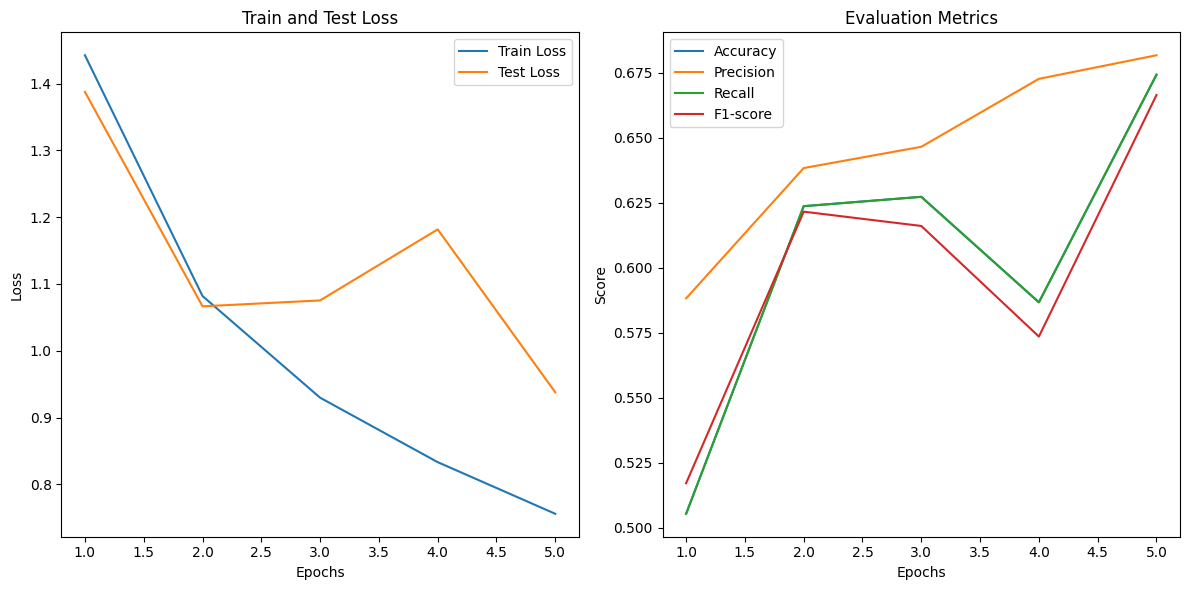

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define a Depthwise Separable Convolution Layer
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Define an Xception-like model for CIFAR-10
class XceptionCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(XceptionCIFAR, self).__init__()

        # Entry Flow
        self.entry_flow = nn.Sequential(
            DepthwiseSeparableConv(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Middle Flow
        self.middle_flow = nn.Sequential(
            DepthwiseSeparableConv(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Exit Flow
        self.exit_flow = nn.Sequential(
            DepthwiseSeparableConv(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = self.fc(x)
        return x

# Data preparation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function
def train_model(model, train_loader, test_loader, num_epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
xception_cifar_model = XceptionCIFAR()
print("Training Xception-like Model on CIFAR-10 Dataset:")
train_losses, test_losses, metrics = train_model(xception_cifar_model, train_loader, test_loader, num_epochs=5)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


In [9]:
!pip install torch torchvision scikit-learn matplotlib tqdm


Files already downloaded and verified
Files already downloaded and verified
Training SENet-like Model on CIFAR-10 Dataset:


100%|██████████| 782/782 [02:09<00:00,  6.05it/s]


Epoch [1/5], Train Loss: 1.2288, Test Loss: 0.9890, Accuracy: 0.6486, Precision: 0.6488, Recall: 0.6486, F1-score: 0.6420


100%|██████████| 782/782 [02:07<00:00,  6.14it/s]


Epoch [2/5], Train Loss: 0.9009, Test Loss: 0.9516, Accuracy: 0.6699, Precision: 0.6937, Recall: 0.6699, F1-score: 0.6751


100%|██████████| 782/782 [02:05<00:00,  6.22it/s]


Epoch [3/5], Train Loss: 0.7663, Test Loss: 0.7904, Accuracy: 0.7245, Precision: 0.7261, Recall: 0.7245, F1-score: 0.7214


100%|██████████| 782/782 [02:12<00:00,  5.90it/s]


Epoch [4/5], Train Loss: 0.6627, Test Loss: 0.7918, Accuracy: 0.7226, Precision: 0.7371, Recall: 0.7226, F1-score: 0.7252


100%|██████████| 782/782 [02:06<00:00,  6.17it/s]


Epoch [5/5], Train Loss: 0.5748, Test Loss: 0.7754, Accuracy: 0.7319, Precision: 0.7368, Recall: 0.7319, F1-score: 0.7298


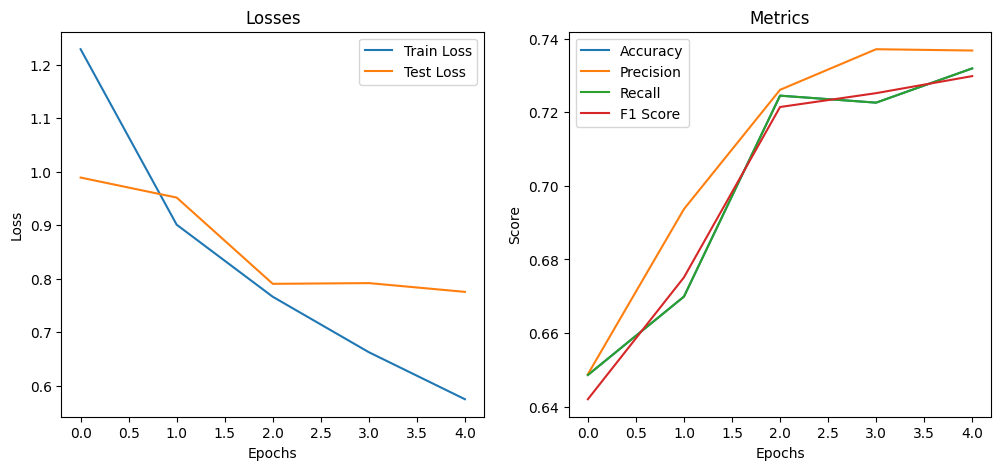

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up CUDA if available and optimize with cuDNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Define the SE Block (Squeeze-and-Excitation)
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3))  # Squeeze: Global Average Pooling
        y = self.fc1(y)
        y = nn.ReLU()(y)  # Excitation: ReLU activation
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)  # Reshape
        return x * y.expand_as(x)  # Scale the input

# Define a SENet-inspired model for CIFAR-10
class SENetCIFAR(nn.Module):
    def __init__(self):
        super(SENetCIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = SEBlock(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = SEBlock(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Adjusted for CIFAR-10 image size
        self.fc2 = nn.Linear(256, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.se1(x)
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.se2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Data preparation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Training function with optimizations
def train_model(model, train_loader, test_loader, num_epochs=5):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation with torch.no_grad for memory efficiency
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Initialize and Train the Model
senet_cifar_model = SENetCIFAR()
print("Training SENet-like Model on CIFAR-10 Dataset:")
train_losses, test_losses, metrics = train_model(senet_cifar_model, train_loader, test_loader, num_epochs=5)

# Plotting the training and test losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the metrics
plt.subplot(1, 2, 2)
plt.plot(metrics['accuracy'], label='Accuracy')
plt.plot(metrics['precision'], label='Precision')
plt.plot(metrics['recall'], label='Recall')
plt.plot(metrics['f1_score'], label='F1 Score')
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.show()
